# Librerias

In [1]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from sklearn.utils import class_weight
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

from sklearn.metrics import confusion_matrix,accuracy_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
from random import shuffle,seed
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval

Using TensorFlow backend.


# Funciones

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,f1_score, confusion_matrix, mean_absolute_error,mean_squared_error, median_absolute_error
from sklearn.preprocessing import normalize
import time
import matplotlib.pyplot as plt

def plot_df(df):
    try:
        from IPython.display import display
        display(df)
    except:
        print(df)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def calculate_metrics(y_true,y_pred,plot=True, title=""):
    dic_return = {}
    dic_return["Precision raw"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["Recall raw"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Precision"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Recall"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 raw"] = f1_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 weighted"] = f1_score(y_true,y_pred,average="weighted",labels=[0,1])
    dic_return["F1 macro"] = f1_score(y_true,y_pred,average="macro",labels=[0,1])
    dic_return["F1 micro"] = f1_score(y_true,y_pred,average="micro",labels=[0,1])
    matriz=confusion_matrix(y_true,y_pred, labels=[0,1])
    if plot:
        df = pd.DataFrame(dic_return)
        df.index = ["False Positive","Confirmed"]
        plot_df(df)
        plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["False Positive","Confirmed"],title)
    dic_return["Confusion Matrix"] = matriz
    return dic_return


def calculate_median_abs_err(real, pred): 
    if len(real.shape) > 1:
        return np.mean([median_absolute_error(real[:,d],pred[:,d]) for d in range(real.shape[1])])   
    else:
        return median_absolute_error(real,pred)
    
def calculate_mean_abs_perce_err(real, pred):
    diff = np.abs((real - pred) / np.clip(np.abs(real), 1e-7, None))
    return 100. * np.mean(diff) #sin *100 es "fractional"

def calculate_Rmean_squar_log_err(real, pred):
    first_log = np.log(np.clip(pred, 1e-7, None) + 1.)
    second_log = np.log(np.clip(real, 1e-7, None) + 1.)
    return np.sqrt(np.mean(np.square(first_log - second_log)))

def evaluate_metadata(real, pred, plot=False):
    dic_res = {}
    dic_res["MSE"] = mean_squared_error(real, pred)
    dic_res["MAE"] = mean_absolute_error(real, pred)
    dic_res["MeAE"] = calculate_median_abs_err(real, pred)
    dic_res["MApE"] = calculate_mean_abs_perce_err(real,pred)
    dic_res["RMSLE"] = calculate_Rmean_squar_log_err(real,pred)
    if plot:
        df = pd.DataFrame(dic_res)
        df.index = ["Real"]
        plot_df(df)
    return dic_res

def evaluate_metadata_raw(real, pred, plot=True, metadata_used=[""]):
    mse_raw = []
    mae_raw = []
    mEae_raw = []
    maPe_raw = []
    rmsle_raw = []
    for d in range(real.shape[1]):        
        dic_aux = evaluate_metadata(real[:,d], pred[:,d], plot=False)
        mse_raw.append(dic_aux["MSE"])
        mae_raw.append(dic_aux["MAE"])
        mEae_raw.append(dic_aux["MeAE"])
        maPe_raw.append(dic_aux["MApE"])
        rmsle_raw.append(dic_aux["RMSLE"])
        
    res_metadata = {}
    res_metadata["MSE"] = mse_raw
    res_metadata["MAE"] = mae_raw
    res_metadata["MeAE"] = mEae_raw
    res_metadata["MApE"] = maPe_raw
    res_metadata["RMSLE"] = rmsle_raw
    
    if plot:
        df = pd.DataFrame(res_metadata)
        df.index = metadata_used
        df.loc["Global"] = np.mean(df, axis=0)
        plot_df(df.transpose())
    res_metadata["MSE"].append(np.mean(mse_raw))
    res_metadata["MAE"].append(np.mean(mae_raw))
    res_metadata["MeAE"].append(np.mean(mEae_raw))
    res_metadata["MApE"].append(np.mean(maPe_raw))
    res_metadata["RMSLE"].append(np.mean(rmsle_raw))
    return res_metadata

    
import keras, gc
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return

import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128, focal=False,alpha=0.6,gamma = 2,save_f='best_mod.hdf5',**args):
    if focal:
        aux_model.compile(loss=binary_focal_loss(alpha=alpha, gamma=gamma),optimizer='Adam',metrics=['accuracy'])
    else:
        aux_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    if not focal:
        calls.append(reduce_lr)
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                      callbacks=calls, **args)
    
    plt.figure(figsize=(12,5))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(12,5))
    if not focal:
        plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    plt.legend(loc="upper left")
    plt.show()
    
    
    #print("Best f1 macro trough iters %f on %d "%(np.max(metrics.val_f1s),np.argmax(metrics.val_f1s)))

    #predichos=aux_model.predict_classes(x_val)
    #calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

# Cargar datos

## Generar imagenes con 3 canales

In [3]:
df_aux = pd.read_csv("../../KOI_Data/kepler_dataset.csv")
labels = (df_aux["NExScI Disposition"] == "CONFIRMED").values*1
labels.shape

(8054,)

In [59]:
n_up = 16
n_down = 32

folder = "/work/work_teamEXOPLANET/"
#folder = "/media/fmena/Respaldo/KOI_LC/MTF/"


In [60]:

channel_1 = np.load(folder+'/MTF_margarita/no_invertidos/MTF_u%d_d%d.npy'%(n_up,n_down))  
channel_2 = np.load(folder+'/MTF_margarita/invertidos/MTF_u%d_d%d.npy'%(n_up,n_down))  
channel_3 = np.load(folder+'/MTF_gabo/npys/MTF_time_u%d_d%d.npy'%(n_up,n_down))  

#channel_1 = np.load(folder+'/normal/MTF_u%d_d%d.npy'%(s,s))  
#channel_2 = np.load(folder+'/invertidos/MTF_u%d_d%d.npy'%(s,s))  
#channel_3 = np.load(folder+'/time/MTF_time_u%d_d%d.npy'%(s,s))  

In [61]:
!ls /work/work_teamEXOPLANET/MTF_margarita/no_invertidos

MTF_u10_d10.npy  MTF_u15_d20.npy  MTF_u32_d32.npy  MTF_u64_d16.npy
MTF_u10_d15.npy  MTF_u15_d30.npy  MTF_u32_d64.npy  MTF_u64_d32.npy
MTF_u10_d20.npy  MTF_u16_d16.npy  MTF_u5_d10.npy   MTF_u64_d64.npy
MTF_u10_d30.npy  MTF_u16_d32.npy  MTF_u5_d15.npy
MTF_u15_d10.npy  MTF_u16_d64.npy  MTF_u5_d20.npy
MTF_u15_d15.npy  MTF_u32_d16.npy  MTF_u5_d30.npy


### Markov cubo, hasta 10 canales

channel_1 = np.load(folder+'/gN_normal/MTF_u%d_d%d.npy'%(s,s))  
channel_2 = np.load(folder+'/gN_invertidos/MTF_u%d_d%d.npy'%(s,s))  

x_all = channel_1[:,:,:,:5]

x_all2 = channel_2[:,:,:,:5]

###### 2 canales (arriba) + data augm

In [62]:
x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_3[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)

x_all2 = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_2[i],channel_3[i]))
    x_all2.append(combined_image)
x_all2 = np.asarray(x_all2)

In [63]:
x_all.shape

(8054, 48, 48, 2)

## Generar conjunto de entrenamiento y validación

In [64]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

,KOI Name,Set
0,K00889.01,Train
1,K01009.01,Train
2,K07621.01,Test
3,K06252.01,Test
4,K00958.01,Unlabeled


In [65]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
0,K00889.01,CONFIRMED,Kepler-75 b,8.884923,169.991686,2455002.992,0.069,2.07004,16053.4,0.114,...,5332.0,4.500,-0.08,0.843,0.821,61.291,474.021,388.2,1,153
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.535940,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
7,K07622.01,FALSE POSITIVE,NaN,36.267167,155.081300,2454988.081,0.214,2.06500,627.1,0.022,...,4264.0,4.637,-0.20,0.620,0.607,3.016,7.472,10.0,1,39
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.039000,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9
10,K00992.01,CONFIRMED,Kepler-745 b,9.931463,136.491280,2454969.491,0.037,5.67800,398.6,0.018,...,5782.0,4.280,0.16,1.220,1.035,4.530,22.901,26.2,2,137


In [66]:
y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print('y_train distribution: 0:%i   1:%i'%(counts_train[0],counts_train[1]))
print('y_val distribution:   0:%i   1:%i'%(counts_val[0],counts_val[1]))

y_train distribution: 0:2729   1:1610
y_val distribution:   0:1247   1:671


In [67]:
x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (4339, 48, 48, 2) (4339,)
Objetos de validación: (1918, 48, 48, 2) (1918,)


###### 2 canales (arriba) + data augm

In [68]:
x_train1 = x_all[mask_train]
x_train2 = x_all2[mask_train]
x_train = np.concatenate([x_train1,x_train2]) #concat

x_val = x_all[mask_test]

if x_train.shape[0] != y_train.shape[0]:
    y_train = np.tile(y_train, (2))
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (8678, 48, 48, 2) (8678,)
Objetos de validación: (1918, 48, 48, 2) (1918,)


## Pruebas CNN utilizando loss = binary_crossentropy

## Modificaciones
* guarda el mejor modelo (pesos) en base a val loss random (10%)

In [75]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 46, 46, 32)        608       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 3200)              0         
__________

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 11s 1ms/step - loss: 0.6217 - acc: 0.6273 - val_loss: 0.5953 - val_acc: 0.6475
Epoch 2/200
7810/7810 [==============================] - 4s 535us/step - loss: 0.5624 - acc: 0.6280 - val_loss: 0.5772 - val_acc: 0.5680
Epoch 3/200
7810/7810 [==============================] - 4s 538us/step - loss: 0.5461 - acc: 0.6357 - val_loss: 0.5729 - val_acc: 0.5449
Epoch 4/200
7810/7810 [==============================] - 4s 535us/step - loss: 0.5402 - acc: 0.6416 - val_loss: 0.5672 - val_acc: 0.5461
Epoch 5/200
7810/7810 [==============================] - 4s 537us/step - loss: 0.5359 - acc: 0.6461 - val_loss: 0.5632 - val_acc: 0.5634
Epoch 6/200
7810/7810 [==============================] - 4s 532us/step - loss: 0.5331 - acc: 0.6519 - val_loss: 0.5643 - val_acc: 0.5657
Epoch 7/200
7810/7810 [==============================] - 4s 528us/step - loss: 0.5319 - acc: 0.6540 - val_loss: 0.5518 - val_acc: 0.

Epoch 35/200
7810/7810 [==============================] - 4s 519us/step - loss: 0.4904 - acc: 0.7073 - val_loss: 0.5064 - val_acc: 0.6970
Epoch 36/200
7810/7810 [==============================] - 4s 531us/step - loss: 0.4882 - acc: 0.7115 - val_loss: 0.5134 - val_acc: 0.6659
Epoch 37/200
7810/7810 [==============================] - 4s 526us/step - loss: 0.4876 - acc: 0.7033 - val_loss: 0.5116 - val_acc: 0.6763
Epoch 38/200
7810/7810 [==============================] - 4s 522us/step - loss: 0.4908 - acc: 0.7097 - val_loss: 0.5107 - val_acc: 0.6763
Epoch 39/200
7810/7810 [==============================] - 4s 523us/step - loss: 0.4850 - acc: 0.7161 - val_loss: 0.5156 - val_acc: 0.6601
Epoch 40/200
7810/7810 [==============================] - 5s 599us/step - loss: 0.4850 - acc: 0.7073 - val_loss: 0.5032 - val_acc: 0.6982
Epoch 41/200
7810/7810 [==============================] - 4s 526us/step - loss: 0.4859 - acc: 0.7051 - val_loss: 0.5042 - val_acc: 0.6970
Epoch 42/200
7810/7810 [==========

7810/7810 [==============================] - 4s 529us/step - loss: 0.4439 - acc: 0.7489 - val_loss: 0.4746 - val_acc: 0.7108
Epoch 104/200
7810/7810 [==============================] - 4s 520us/step - loss: 0.4415 - acc: 0.7490 - val_loss: 0.4738 - val_acc: 0.7166
Epoch 105/200
7810/7810 [==============================] - 4s 533us/step - loss: 0.4351 - acc: 0.7563 - val_loss: 0.4580 - val_acc: 0.7419
Epoch 106/200
7810/7810 [==============================] - 4s 522us/step - loss: 0.4342 - acc: 0.7586 - val_loss: 0.4664 - val_acc: 0.7143
Epoch 107/200
7810/7810 [==============================] - 4s 528us/step - loss: 0.4350 - acc: 0.7520 - val_loss: 0.4564 - val_acc: 0.7454
Epoch 108/200
7810/7810 [==============================] - 4s 529us/step - loss: 0.4381 - acc: 0.7460 - val_loss: 0.4704 - val_acc: 0.7154
Epoch 109/200
7810/7810 [==============================] - 4s 554us/step - loss: 0.4366 - acc: 0.7562 - val_loss: 0.4655 - val_acc: 0.7200
Epoch 110/200
7810/7810 [================

7810/7810 [==============================] - 4s 513us/step - loss: 0.4065 - acc: 0.7793 - val_loss: 0.4390 - val_acc: 0.7488
Epoch 138/200
7810/7810 [==============================] - 4s 512us/step - loss: 0.4042 - acc: 0.7853 - val_loss: 0.4324 - val_acc: 0.7535
Epoch 139/200
7810/7810 [==============================] - 4s 511us/step - loss: 0.4044 - acc: 0.7795 - val_loss: 0.4349 - val_acc: 0.7477
Epoch 140/200
7810/7810 [==============================] - 4s 521us/step - loss: 0.4089 - acc: 0.7805 - val_loss: 0.4434 - val_acc: 0.7477
Epoch 141/200
7810/7810 [==============================] - 4s 513us/step - loss: 0.4101 - acc: 0.7752 - val_loss: 0.4440 - val_acc: 0.7442
Epoch 142/200
7810/7810 [==============================] - 4s 521us/step - loss: 0.4037 - acc: 0.7819 - val_loss: 0.4465 - val_acc: 0.7523
Epoch 143/200
7810/7810 [==============================] - 4s 522us/step - loss: 0.4082 - acc: 0.7849 - val_loss: 0.4396 - val_acc: 0.7569
Epoch 144/200
7810/7810 [================

7810/7810 [==============================] - 4s 526us/step - loss: 0.3900 - acc: 0.7883 - val_loss: 0.4273 - val_acc: 0.7615
Epoch 172/200
7810/7810 [==============================] - 4s 534us/step - loss: 0.3938 - acc: 0.7919 - val_loss: 0.4245 - val_acc: 0.7558
Epoch 173/200
7810/7810 [==============================] - 4s 530us/step - loss: 0.3918 - acc: 0.7946 - val_loss: 0.4274 - val_acc: 0.7488
Epoch 174/200
7810/7810 [==============================] - 4s 521us/step - loss: 0.3834 - acc: 0.8029 - val_loss: 0.4461 - val_acc: 0.7442
Epoch 175/200
7810/7810 [==============================] - 4s 526us/step - loss: 0.3853 - acc: 0.7982 - val_loss: 0.4446 - val_acc: 0.7454
Epoch 176/200
7810/7810 [==============================] - 4s 530us/step - loss: 0.3856 - acc: 0.7982 - val_loss: 0.4181 - val_acc: 0.7673
Epoch 177/200
7810/7810 [==============================] - 4s 524us/step - loss: 0.3893 - acc: 0.7977 - val_loss: 0.4156 - val_acc: 0.7569
Epoch 178/200
7810/7810 [================

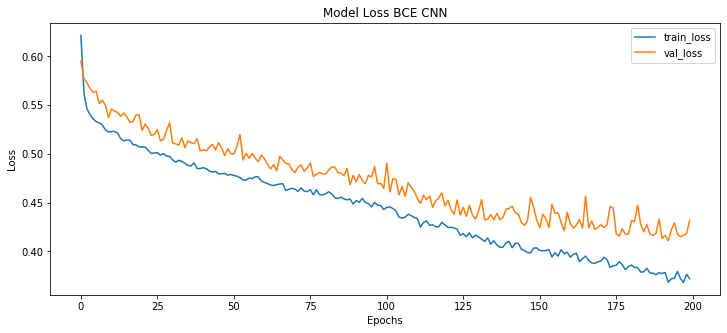

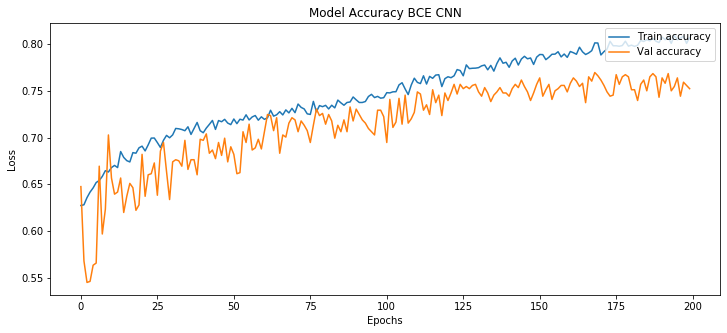

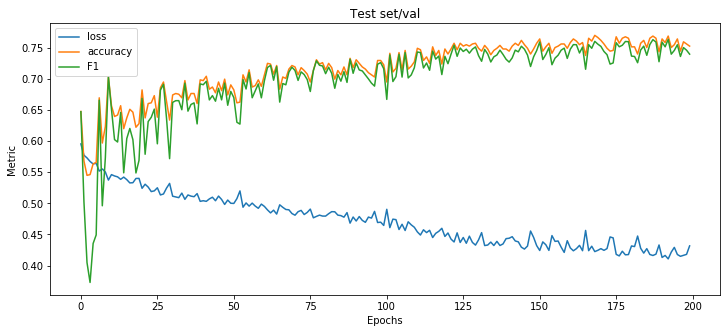

In [76]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, save_f='16u_32d_N.h5')  #save model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 46, 46, 32)        608       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 3200)              0         
__________

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.833072,0.852446,0.842648,0.791917,0.770143,0.793014
Confirmed,0.713396,0.682563,0.697639,0.791917,0.770143,0.793014


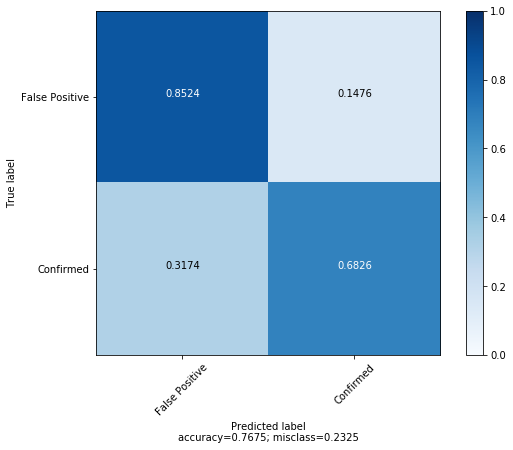

{'Precision raw': array([0.8330721 , 0.71339564]),
 'Recall raw': array([0.85244587, 0.68256334]),
 'F1 raw': array([0.84264764, 0.69763899]),
 'F1 weighted': 0.7919172964640764,
 'F1 macro': 0.7701433181825454,
 'F1 micro': 0.7930135557872783,
 'Confusion Matrix': array([[1063,  184],
        [ 213,  458]])}

In [79]:
model = keras.models.load_model("16u_32d_N.h5")
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

In [81]:
%%time
predichos=model.predict_classes(x_val)


CPU times: user 4.61 s, sys: 96.9 ms, total: 4.71 s
Wall time: 378 ms


In [78]:
model.save("16u_32d_N_last.h5")

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 10s 1ms/step - loss: 0.6279 - acc: 0.6366 - val_loss: 0.6021 - val_acc: 0.6129
Epoch 2/200
7810/7810 [==============================] - 4s 556us/step - loss: 0.5632 - acc: 0.6251 - val_loss: 0.5826 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 4s 530us/step - loss: 0.5451 - acc: 0.6389 - val_loss: 0.5694 - val_acc: 0.5634
Epoch 4/200
7810/7810 [==============================] - 4s 539us/step - loss: 0.5401 - acc: 0.6388 - val_loss: 0.5631 - val_acc: 0.6809
Epoch 5/200
7810/7810 [==============================] - 4s 539us/step - loss: 0.5372 - acc: 0.6389 - val_loss: 0.5615 - val_acc: 0.5691
Epoch 6/200
7810/7810 [==============================] - 4s 530us/step - loss: 0.5347 - acc: 0.6423 - val_loss: 0.5635 - val_acc: 0.5680
Epoch 7/200
7810/7810 [==============================] - 4s 521us/step - loss: 0.5328 - acc: 0.6433 - val_loss: 0.5555 - val_acc: 0.

Epoch 35/200
7810/7810 [==============================] - 4s 545us/step - loss: 0.4936 - acc: 0.6972 - val_loss: 0.5031 - val_acc: 0.7074
Epoch 36/200
7810/7810 [==============================] - 4s 531us/step - loss: 0.4880 - acc: 0.7041 - val_loss: 0.5117 - val_acc: 0.7016
Epoch 37/200
7810/7810 [==============================] - 4s 526us/step - loss: 0.4922 - acc: 0.7010 - val_loss: 0.5028 - val_acc: 0.7108
Epoch 38/200
7810/7810 [==============================] - 4s 530us/step - loss: 0.4878 - acc: 0.7068 - val_loss: 0.5137 - val_acc: 0.6705
Epoch 39/200
7810/7810 [==============================] - 4s 535us/step - loss: 0.4905 - acc: 0.7022 - val_loss: 0.5189 - val_acc: 0.6463
Epoch 40/200
7810/7810 [==============================] - 4s 528us/step - loss: 0.4879 - acc: 0.7018 - val_loss: 0.5072 - val_acc: 0.6624
Epoch 41/200
7810/7810 [==============================] - 4s 512us/step - loss: 0.4823 - acc: 0.7152 - val_loss: 0.5084 - val_acc: 0.6763
Epoch 42/200
7810/7810 [==========

7810/7810 [==============================] - 4s 519us/step - loss: 0.4248 - acc: 0.7695 - val_loss: 0.4310 - val_acc: 0.7719
Epoch 104/200
7810/7810 [==============================] - 4s 505us/step - loss: 0.4213 - acc: 0.7735 - val_loss: 0.4410 - val_acc: 0.7627
Epoch 105/200
7810/7810 [==============================] - 4s 504us/step - loss: 0.4264 - acc: 0.7679 - val_loss: 0.4538 - val_acc: 0.7385
Epoch 106/200
7810/7810 [==============================] - 4s 512us/step - loss: 0.4198 - acc: 0.7740 - val_loss: 0.4355 - val_acc: 0.7546
Epoch 107/200
7810/7810 [==============================] - 4s 500us/step - loss: 0.4227 - acc: 0.7703 - val_loss: 0.4345 - val_acc: 0.7604
Epoch 108/200
7810/7810 [==============================] - 4s 510us/step - loss: 0.4155 - acc: 0.7755 - val_loss: 0.4439 - val_acc: 0.7546
Epoch 109/200
7810/7810 [==============================] - 4s 524us/step - loss: 0.4181 - acc: 0.7771 - val_loss: 0.4457 - val_acc: 0.7535
Epoch 110/200
7810/7810 [================

7810/7810 [==============================] - 4s 522us/step - loss: 0.4040 - acc: 0.7869 - val_loss: 0.4427 - val_acc: 0.7535
Epoch 138/200
7810/7810 [==============================] - 4s 512us/step - loss: 0.4078 - acc: 0.7782 - val_loss: 0.4256 - val_acc: 0.7604
Epoch 139/200
7810/7810 [==============================] - 4s 522us/step - loss: 0.4054 - acc: 0.7809 - val_loss: 0.4180 - val_acc: 0.7569
Epoch 140/200
7810/7810 [==============================] - 4s 516us/step - loss: 0.4023 - acc: 0.7807 - val_loss: 0.4328 - val_acc: 0.7488
Epoch 141/200
7810/7810 [==============================] - 4s 520us/step - loss: 0.4031 - acc: 0.7858 - val_loss: 0.4223 - val_acc: 0.7684
Epoch 142/200
7810/7810 [==============================] - 4s 511us/step - loss: 0.4035 - acc: 0.7880 - val_loss: 0.4498 - val_acc: 0.7408
Epoch 143/200
7810/7810 [==============================] - 4s 512us/step - loss: 0.4047 - acc: 0.7891 - val_loss: 0.4227 - val_acc: 0.7615
Epoch 144/200
7810/7810 [================

7810/7810 [==============================] - 4s 520us/step - loss: 0.3890 - acc: 0.7972 - val_loss: 0.4168 - val_acc: 0.7581
Epoch 172/200
7810/7810 [==============================] - 4s 517us/step - loss: 0.3974 - acc: 0.7869 - val_loss: 0.4239 - val_acc: 0.7638
Epoch 173/200
7810/7810 [==============================] - 4s 521us/step - loss: 0.3896 - acc: 0.7941 - val_loss: 0.4230 - val_acc: 0.7638
Epoch 174/200
7810/7810 [==============================] - 4s 515us/step - loss: 0.3853 - acc: 0.7960 - val_loss: 0.4099 - val_acc: 0.7638
Epoch 175/200
7810/7810 [==============================] - 4s 525us/step - loss: 0.3925 - acc: 0.7917 - val_loss: 0.4221 - val_acc: 0.7638
Epoch 176/200
7810/7810 [==============================] - 4s 520us/step - loss: 0.3957 - acc: 0.7892 - val_loss: 0.4148 - val_acc: 0.7800
Epoch 177/200
7810/7810 [==============================] - 4s 524us/step - loss: 0.3875 - acc: 0.8022 - val_loss: 0.4070 - val_acc: 0.7730
Epoch 178/200
7810/7810 [================

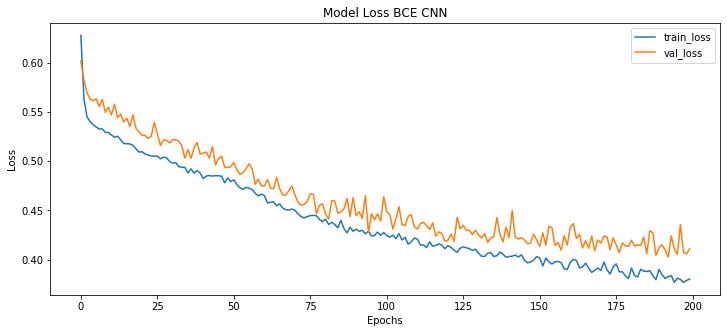

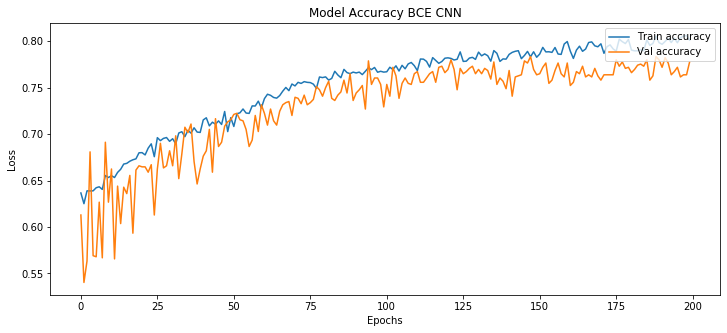

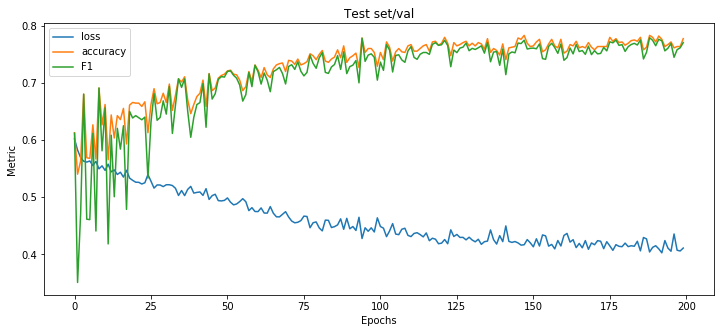

In [73]:
from sklearn.utils import class_weight

# Calculate the weights for each class so that we can balance the data
weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, save_f='16u_32d_CW.h5', class_weight=weights)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 46, 46, 32)        608       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 3200)              0         
__________

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.857755,0.802727,0.829329,0.787676,0.769798,0.785193
Confirmed,0.672437,0.752608,0.710267,0.787676,0.769798,0.785193


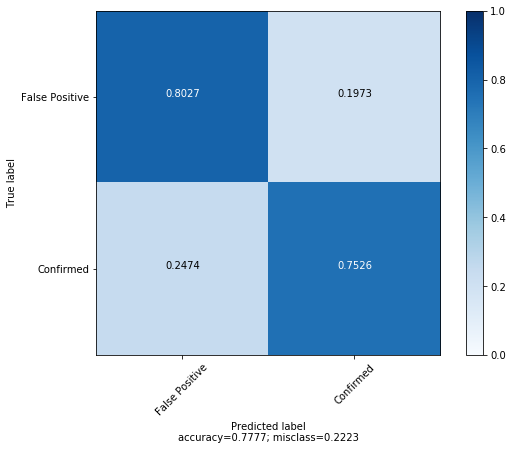

{'Precision raw': array([0.85775493, 0.67243675]),
 'Recall raw': array([0.80272654, 0.75260805]),
 'F1 raw': array([0.82932891, 0.71026723]),
 'F1 weighted': 0.7876759475580789,
 'F1 macro': 0.7697980719595141,
 'F1 micro': 0.7851929092805006,
 'Confusion Matrix': array([[1001,  246],
        [ 166,  505]])}

In [74]:
model = keras.models.load_model("16u_32d_CW.h5")
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

In [56]:
model = Sequential()


#disminuir o aumentar
model.add(Conv2D(32, (5, 5), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))


model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(MaxPooling2D((2,2))

model.add(GlobalAveragePooling2D())
#model.add(GlobalMaxPool2D())

#model.add(MaxPooling2D((2,2)))
#model.add(Flatten())

#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))

#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 60, 60, 32)        1632      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 12, 12, 128)       73856     
__________

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 21s 3ms/step - loss: 0.6709 - acc: 0.6388 - val_loss: 0.6920 - val_acc: 0.5403
Epoch 2/200
7810/7810 [==============================] - 15s 2ms/step - loss: 0.6035 - acc: 0.6388 - val_loss: 0.6104 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 14s 2ms/step - loss: 0.5672 - acc: 0.6388 - val_loss: 0.6012 - val_acc: 0.5403
Epoch 4/200
7810/7810 [==============================] - 14s 2ms/step - loss: 0.5640 - acc: 0.6388 - val_loss: 0.5989 - val_acc: 0.5403
Epoch 5/200
7810/7810 [==============================] - 14s 2ms/step - loss: 0.5592 - acc: 0.6388 - val_loss: 0.5940 - val_acc: 0.5403
Epoch 6/200
7810/7810 [==============================] - 14s 2ms/step - loss: 0.5481 - acc: 0.6392 - val_loss: 0.5730 - val_acc: 0.5403
Epoch 7/200
7810/7810 [==============================] - 15s 2ms/step - loss: 0.5411 - acc: 0.6325 - val_loss: 0.5623 - val_acc: 0.5853
E

7810/7810 [==============================] - 15s 2ms/step - loss: 0.4234 - acc: 0.7617 - val_loss: 0.4661 - val_acc: 0.6970
Epoch 70/200
7810/7810 [==============================] - 14s 2ms/step - loss: 0.4177 - acc: 0.7609 - val_loss: 0.4429 - val_acc: 0.7258
Epoch 71/200
7810/7810 [==============================] - 15s 2ms/step - loss: 0.4133 - acc: 0.7666 - val_loss: 0.4463 - val_acc: 0.7362
Epoch 72/200
7810/7810 [==============================] - 14s 2ms/step - loss: 0.4103 - acc: 0.7709 - val_loss: 0.4410 - val_acc: 0.7258
Epoch 73/200
7810/7810 [==============================] - 14s 2ms/step - loss: 0.4138 - acc: 0.7626 - val_loss: 0.4416 - val_acc: 0.7281
Epoch 74/200
7810/7810 [==============================] - 14s 2ms/step - loss: 0.4067 - acc: 0.7686 - val_loss: 0.4479 - val_acc: 0.7304
Epoch 75/200
7810/7810 [==============================] - 14s 2ms/step - loss: 0.4058 - acc: 0.7726 - val_loss: 0.4337 - val_acc: 0.7304
Epoch 76/200
7810/7810 [==============================

7810/7810 [==============================] - 14s 2ms/step - loss: 0.3080 - acc: 0.8416 - val_loss: 0.3918 - val_acc: 0.7811
Epoch 138/200
7810/7810 [==============================] - 14s 2ms/step - loss: 0.3126 - acc: 0.8399 - val_loss: 0.3988 - val_acc: 0.7696
Epoch 139/200
7810/7810 [==============================] - 14s 2ms/step - loss: 0.3051 - acc: 0.8420 - val_loss: 0.3952 - val_acc: 0.7730
Epoch 140/200
7810/7810 [==============================] - 15s 2ms/step - loss: 0.3063 - acc: 0.8414 - val_loss: 0.3997 - val_acc: 0.7776
Epoch 141/200
7810/7810 [==============================] - 15s 2ms/step - loss: 0.3137 - acc: 0.8353 - val_loss: 0.4016 - val_acc: 0.7880
Epoch 142/200
7810/7810 [==============================] - 14s 2ms/step - loss: 0.3076 - acc: 0.8394 - val_loss: 0.4023 - val_acc: 0.7903
Epoch 143/200
7810/7810 [==============================] - 14s 2ms/step - loss: 0.3050 - acc: 0.8396 - val_loss: 0.4502 - val_acc: 0.7419
Epoch 144/200
7810/7810 [=======================

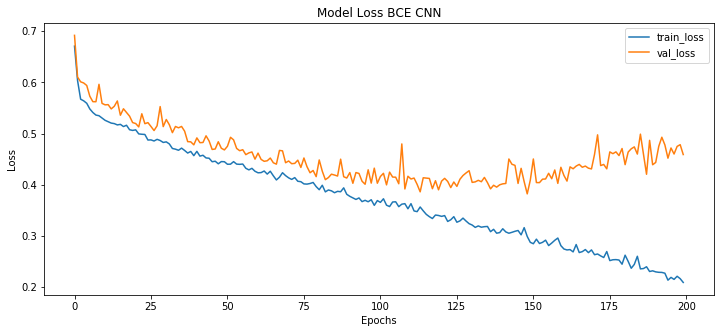

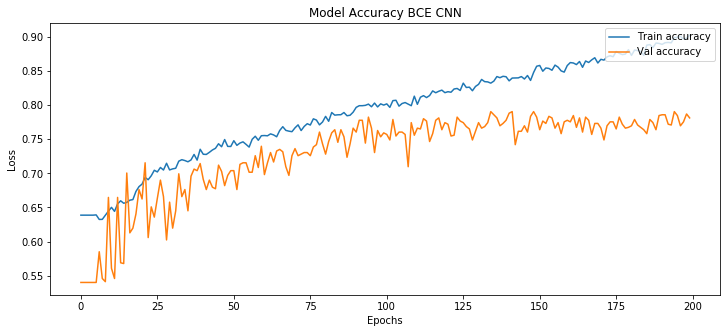

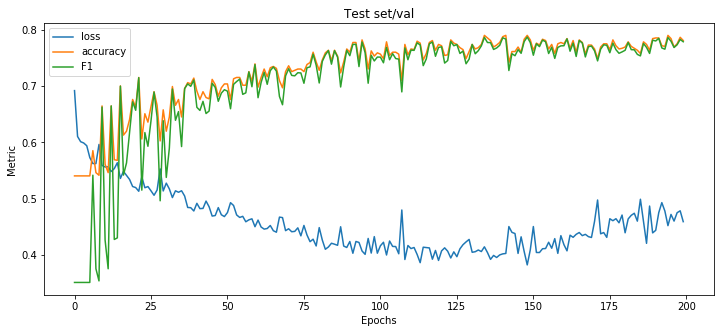

In [57]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2)  #save model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 60, 60, 32)        1632      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 12, 12, 128)       73856     
__________

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.845309,0.801925,0.823045,0.777958,0.758607,0.775808
Confirmed,0.663946,0.727273,0.694168,0.777958,0.758607,0.775808


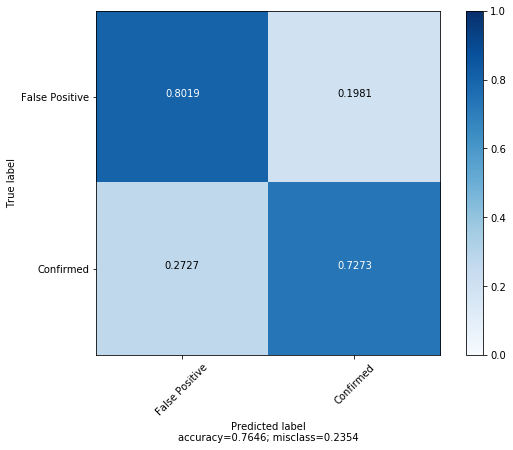

{'Precision raw': array([0.84530854, 0.66394558]),
 'Recall raw': array([0.80192462, 0.72727273]),
 'F1 raw': array([0.82304527, 0.69416785]),
 'F1 weighted': 0.7779583301843942,
 'F1 macro': 0.7586065597761504,
 'F1 micro': 0.7758081334723671,
 'Confusion Matrix': array([[1000,  247],
        [ 183,  488]])}

In [58]:
keras.losses.binary_focal_loss_fixed = keras.losses.mse
model = keras.models.load_model("best_mod.hdf5")
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 32)        0         
______________________

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 2/200
7810/7810 [==============================] - 37s 5ms/step - loss: 0.5944 - acc: 0.6338 - val_loss: 0.6033 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 41s 5ms/step - loss: 0.5652 - acc: 0.6405 - val_loss: 0.5992 - val_acc: 0.5415
Epoch 4/200
7810/7810 [==============================] - 40s 5ms/step - loss: 0.5632 - acc: 0.6374 - val_loss: 0.5961 - val_acc: 0.5565
Epoch 5/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.5579 - acc: 0.6484 - val_loss: 0.5914 - val_acc: 0.5910
Epoch 6/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.5543 - acc: 0.6456 - val_loss: 0.5864 - val_acc: 0.6025
Epoch 7/200
7810/7810 [==============================] - 38s 5ms/step - loss: 0.5464 - acc: 0.6465 - val_loss: 0.5733 - val_acc: 0.6198
Epoch 8/200
7810/7810 [==============================] - 38s 5ms/step - loss: 0.5448 - acc: 0.6461 - val_loss: 0.5693 - val_acc: 0.6233
Epoch 9/200
7810/7810 [=========================

7810/7810 [==============================] - 38s 5ms/step - loss: 0.4505 - acc: 0.7533 - val_loss: 0.4505 - val_acc: 0.7431
Epoch 71/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.4468 - acc: 0.7565 - val_loss: 0.4577 - val_acc: 0.7212
Epoch 72/200
7810/7810 [==============================] - 38s 5ms/step - loss: 0.4466 - acc: 0.7538 - val_loss: 0.4644 - val_acc: 0.7143
Epoch 73/200
7810/7810 [==============================] - 40s 5ms/step - loss: 0.4447 - acc: 0.7589 - val_loss: 0.4490 - val_acc: 0.7558
Epoch 74/200
7810/7810 [==============================] - 40s 5ms/step - loss: 0.4511 - acc: 0.7517 - val_loss: 0.4410 - val_acc: 0.7604
Epoch 75/200
7810/7810 [==============================] - 37s 5ms/step - loss: 0.4462 - acc: 0.7529 - val_loss: 0.4543 - val_acc: 0.7327
Epoch 76/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.4404 - acc: 0.7615 - val_loss: 0.4855 - val_acc: 0.6959
Epoch 77/200
7810/7810 [==============================

7810/7810 [==============================] - 39s 5ms/step - loss: 0.3961 - acc: 0.7876 - val_loss: 0.4382 - val_acc: 0.7281
Epoch 139/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.3958 - acc: 0.7885 - val_loss: 0.4172 - val_acc: 0.7558
Epoch 140/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.3963 - acc: 0.7896 - val_loss: 0.4442 - val_acc: 0.7281
Epoch 141/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.3933 - acc: 0.7876 - val_loss: 0.4178 - val_acc: 0.7627
Epoch 142/200
7810/7810 [==============================] - 38s 5ms/step - loss: 0.3989 - acc: 0.7908 - val_loss: 0.4189 - val_acc: 0.7581
Epoch 143/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.3981 - acc: 0.7825 - val_loss: 0.4158 - val_acc: 0.7627
Epoch 144/200
7810/7810 [==============================] - 39s 5ms/step - loss: 0.3937 - acc: 0.7887 - val_loss: 0.4125 - val_acc: 0.7569
Epoch 145/200
7810/7810 [=======================

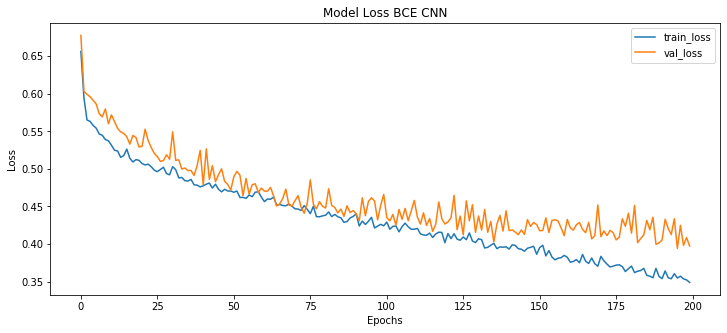

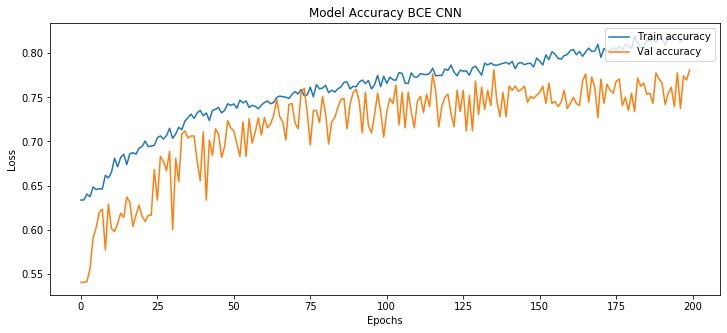

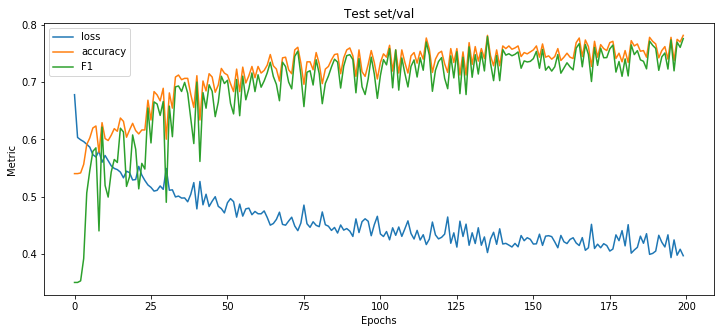

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

#model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2)  #save model